In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [34]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from zoobot.active_learning import metrics, simulation_timeline

# Investigate Active Learning Subject Selection (Including Through Time)

### Load Catalog (for subject details)

In [9]:
gz2_catalog_loc = '../data/gz2_classifications_and_subjects.csv'
if not os.path.isfile(gz2_catalog_loc):
    !dvc pull -r s3 {gz2_catalog_loc}.dvc
gz2_catalog = pd.read_csv(gz2_catalog_loc, usecols=None, dtype={'subject_id': str})

In [10]:
catalog = gz2_catalog
del gz2_catalog
# TODO could extend this to include NSA catalog properties, but matching all is a bit tricky

In [25]:
# rename for consistency with Panoptes
catalog['smooth-or-featured_smooth_count'] = catalog['t01_smooth_or_features_a01_smooth_count']
catalog['smooth-or-featured_smooth_fraction'] = catalog['t01_smooth_or_features_a01_smooth_fraction']

catalog['smooth-or-featured_total-votes'] = catalog['t01_smooth_or_features_a01_smooth_count'] + catalog['t01_smooth_or_features_a02_features_or_disk_count'] + catalog['t01_smooth_or_features_a03_star_or_artifact_count']
catalog['bar_yes_fraction'] = catalog['t03_bar_a06_bar_fraction']
catalog['bar_total-votes'] = catalog['t03_bar_a06_bar_count'] + catalog['t03_bar_a07_no_bar_count']

In [12]:
catalog['subject_id'] = catalog['id'].astype(str)
if QUESTION == 'smooth':
    catalog['total_votes']  = catalog['smooth-or-featured_total-votes']
    catalog['label']  = catalog['t01_smooth_or_features_a01_smooth_count']
elif QUESTION == 'bars':
    catalog['total_votes']  = catalog['bar_total-votes']
    catalog['label']  = catalog['t03_bar_a06_bar_count']

### Select Question to Investigate

In [157]:
QUESTION = 'smooth'
save_dir = '../analysis/active_learning_gz2_smooth'

# QUESTION = 'bars'
# save_dir = '../analysis/active_learning_gz2_bars'

if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

### Download Pickled Iteration States

In [158]:
if QUESTION == 'smooth':
    states_dir = '../results/al_mutual_128px_smooth_0e0d3cb7/states'
    # n_acquired = 128
    !aws s3 sync --exclude "*" --include "*.pickle" s3://galaxy-zoo/results/al_mutual_128px_smooth_0e0d3cb7 {states_dir}
if QUESTION == 'bars':
    states_dir = '../results/al-iter-arms-53128718-mutual-bars-with-pickle'
    n_acquired = 256
    !aws s3 sync --exclude "*" --include "*.pickle" s3://galaxy-zoo/results/al-iter-arms-53128718-mutual-bars-with-pickle {states_dir}

### Load Iteration States as Timeline

In [160]:
states = []
n_iterations = 23
for iteration_n in range(n_iterations):
    state_dir = os.path.join(states_dir, 'iteration_{}'.format(iteration_n))
    states.append(metrics.load_iteration_state(state_dir))


In [ ]:
key_catalog_cols = [
    'smooth-or-featured_smooth_count',
    'smooth-or-featured_smooth_fraction',
    'smooth-or-featured_total-votes',
    'bar_yes_fraction',
    'bar_total-votes',
    'label',
    'total_votes',
    'subject_id'
]

# takes a few minutes
timeline = simulation_timeline.Timeline(states, catalog[key_catalog_cols], n_acquired=n_acquired, save_dir=save_dir)

/Data/repos/zoobot/zoobot/active_learning/simulated_metrics.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  filtered_catalog['subject_id'] = filtered_catalog['subject_id'].astype(str)
/Data/repos/zoobot/zoobot/active_learning/simulated_metrics.py:112: RuntimeWarning: invalid value encountered in true_divide
  self.abs_rho_error = np.abs(self.mean_rho_prediction - (self.labels / self.total_votes))
/Data/repos/zoobot/zoobot/active_learning/simulated_metrics.py:113: RuntimeWarning: invalid value encountered in true_divide
  self.square_rho_error = ((self.labels / self.total_votes) - self.mean_rho_prediction) ** 2.


In [ ]:
len(timeline._models)

### Pick Feature to Investigate

In [ ]:
# value = 'smooth-or-featured_smooth_fraction'
value = 'bar_yes_fraction'

In [ ]:
### Extract Values of Feature

acquired = []
random = []
acquired_dummy = []
random_dummy = []

for iteration_n in range(n_iterations):
    values = timeline._models[iteration_n].catalog[value]
    acquired_values = values[:timeline.n_acquired]
    acquired.extend(list(acquired_values))
    random.extend(list(values))
    # dummies records which step was used, for 2D histogram plotting
    acquired_dummy.extend([iteration_n for _ in range(len(acquired_values))])
    random_dummy.extend([iteration_n for _ in range(len(values))])

### Visualise Feature By 2D Hist (value by step)

In [ ]:
# from matplotlib import colors 

In [ ]:

# normalizer = colors.Normalize(vmin=0, vmax=60)

sns.set(font_scale=1.1)
sns.set_style('white')

fig = plt.figure(figsize=(8, 8))
spacing = 0
grid = plt.GridSpec(n_iterations + spacing, 2, wspace=.4, hspace=.4)
ax0 = plt.subplot(grid[:1, 0])  # top bar is a 2D hist with only one y value (1), double height for clarity
ax1 = plt.subplot(grid[2 + spacing:, 0])  # lower plot is 2D hist where y is step and x is values


# fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, sharey=True)
ax0.hist2d(random, np.ones_like(random_dummy), bins=(10, 1), cmap='Blues')
ax0.axes.get_yaxis().set_visible(False)
ax0.axes.get_xaxis().set_visible(False)
# ax0.ticks_visible=False
ax1.hist2d(acquired, acquired_dummy, bins=(10, n_iterations), cmap='Blues')
ax1.set_title('Acquired')
ax0.set_title('Random')
# ax0.set_ylabel('Iteration')
ax1.set_ylabel('Iteration')

if 'smooth' in value:
    ax1.set_xlabel(r'Smooth Vote Fraction $\rho$')
else:
    ax1.set_xlabel(r'Bar Vote Fraction $\rho$')

plt.savefig(os.path.join(save_dir, value + 'acquired_by_step.png'))

### Visualise Feature By overlaid 1D Hist (value at each step)

In [ ]:
sns.set_style('white')
fig, ax = plt.subplots()
alpha = 0.15
# cmap = plt.get_cmap('magma')
n_bins = 10
all_labels = []
all_acquired_labels = []
for iteration_n in range(n_iterations):
    color_float = iteration_n / n_iterations
    assert isinstance(color_float, float)  # this will fail for python2
    labels = timeline._models[iteration_n].catalog[value]
    all_labels.extend(labels)
    acquired_labels = labels[:timeline.n_acquired]
    all_acquired_labels.extend(acquired_labels)
    if iteration_n == 0:
        bins = n_bins
        label = 'Acquired (Per Iteration)'
    else:
        label = None
    _, bins, _ = ax.hist(acquired_labels, bins=bins, alpha=alpha, histtype='step', color='k', density=True, label=label)
    mean_acquired.append(acquired_values)
bin_width = (bins[-1] - bins[0]) / len(bins)

# timeline._models[iteration_n].catalog[value][:timeline.n_acquired]
ax.hist(all_acquired_labels,histtype='step', bins=bins, density=True, linewidth=3., label='Acquired (Total)')
ax.hist(all_labels,histtype='step', bins=bins, density=True, linewidth=3., label='Random')

if 'smooth' in value:
    ax.set_xlabel(r'Smooth Vote Fraction $\rho$')
else:
    ax.set_xlabel(r'Bar Vote Fraction $\rho$')
ax.set_ylabel('Galaxies (Normalised)')
ax.legend()

fig.tight_layout()
# plt.savefig(os.path.join(save_dir, value + 'acquired_overlaid.png'))

### Alternative Overlay (Deprecated)

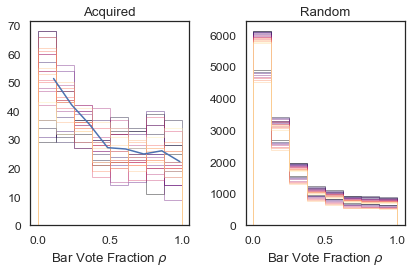

In [142]:
sns.set_style('white')
fig, (ax0, ax1) = plt.subplots(ncols=2)
alpha = 0.4
cmap = plt.get_cmap('magma')
n_bins = 8
mean_acquired = []
mean_random = []
for iteration_n in range(n_iterations):
    color_float = iteration_n / n_iterations
    assert isinstance(color_float, float)  # this will fail for python2
    labels = timeline._models[iteration_n].catalog['bar_yes_fraction']
    acquired_labels = labels[:timeline.n_acquired]
    if iteration_n == 0:
        bins = n_bins
    acquired_values, bins, _ = ax0.hist(acquired_labels, bins=bins, alpha=alpha, histtype='step', color=cmap(color_float))
    mean_acquired.append(acquired_values)
    random_values = ax1.hist(labels, alpha=alpha, histtype='step', bins=bins, color=cmap(color_float))
    ax0.set_title('Acquired')
    ax1.set_title('Random')
    ax0.set_xlabel(r'Bar Vote Fraction $\rho$')
    ax1.set_xlabel(r'Bar Vote Fraction $\rho$')
bin_width = (bins[-1] - bins[0]) / len(bins)
ax0.plot(bins[:-1] + bin_width, np.mean(mean_acquired, axis=0))
# better: turn other bins to trace, and plot an overall and random histogram
fig.tight_layout()
plt.savefig(os.path.join(save_dir, value + 'acquired_overlaid.png'))